# LightFM

In [1]:
!pip install lightfm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 310 kB 40.3 MB/s eta 0:00:01
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=888284 sha256=048f24b565e4a65eef71a0e2a15f097af7fbb50f26eed6e67632041bc156e2ed
  Stored in directory: /home/dl4747/.cache/pip/wheels/ec/bb/51/9c487d021c1373b691d13cadca0b65b6852627b1f3f43550fa
Successfully built lightfm
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [2]:
!unzip data.zip

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [4]:
train_data = pq.read_table('data/train_ratings_small.parquet').to_pandas()
test_data = pq.read_table('data/test_ratings_small.parquet').to_pandas()
val_data = pq.read_table('data/val_ratings_small.parquet').to_pandas()

In [5]:
from lightfm.cross_validation import random_train_test_split

def transform_interaction(df, test_percent):
    interaction = pd.pivot_table(df, index='userId', columns='movieId', values='rating')
    interaction = interaction.fillna(0)
    
    all_csr = csr_matrix(interaction.values)
    
    (train_matrix, test_matrix) = random_train_test_split(all_csr, test_percentage=test_percent)
    
    return (train_matrix, test_matrix)

In [6]:
def lightfm_train(train, rank, regParam, maxIter, model_type='warp'):
    if model_type == 'bpr':
        model = LightFM(loss='bpr',
                no_components=rank,
                user_alpha=regParam)
        
    else:    
        model = LightFM(loss='warp',
                no_components=rank,
                user_alpha=regParam)

    model = model.fit(train, epochs=maxIter,verbose=False)
    
    return model

In [7]:
from lightfm.evaluation import precision_at_k
from time import time

def train_and_test(train, test, rank, regParam, maxIter, top=500, model_type='warp'):
    st = time()
    
    model = lightfm_train(train, rank, regParam, maxIter, model_type='warp')
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    p_at_k = precision_at_k(model, test, k=top).mean()
    
    t = round(time()-st, 5)
    
    print('Model with maxIter = {}, reg = {}, rank = {} complete'.format(maxIter,regParam,rank))
    print('Precision at K:', p_at_k)
    print('Accuracy Train =',auc_train, 'Accuracy Test =',auc_test)
    print('Time used:', t)
    
    return p_at_k,auc_train,auc_test, t

In [8]:
df = pd.concat([ train_data,test_data, val_data])

In [9]:
df.head()

,userId,movieId,rating,date
0,1,1,4.0,2000-07-30 14:45:03
1,1,3,4.0,2000-07-30 14:20:47
2,1,6,4.0,2000-07-30 14:37:04
3,1,47,5.0,2000-07-30 15:03:35
4,1,50,5.0,2000-07-30 14:48:51


In [10]:
train_1, test_1 = transform_interaction(df, 0.3)

In [11]:
from pandas._libs.tslibs import timedeltas
maxIters = [5,10,15]
regParams = [0.1, 0.01]
ranks = [4,5,6,7,8,9,10,11,12]
precision_at_ks = {}
times = {}
auc_train = {}
auc_test = {}

In [12]:
import itertools
for r in ranks:
  for Iter in maxIters:
    for reg in regParams:
      p_at_k,auc_1,auc_2,t = train_and_test(train_1, test_1,r,reg,Iter)
      precision_at_ks[(r,Iter,reg)] = p_at_k
      auc_train[(r,Iter,reg)] = auc_1
      auc_test[(r,Iter,reg)] = auc_2
      times[(r,Iter,reg)] = t

Model with maxIter = 5, reg = 0.1, rank = 4 complete
Precision at K: 0.0030491804
Accuracy Train = 0.53848815 Accuracy Test = 0.53371805
Time used: 3.42461
Model with maxIter = 5, reg = 0.01, rank = 4 complete
Precision at K: 0.04189508
Accuracy Train = 0.9018851 Accuracy Test = 0.8827717
Time used: 2.64079
Model with maxIter = 10, reg = 0.1, rank = 4 complete
Precision at K: 0.0032065576
Accuracy Train = 0.54719806 Accuracy Test = 0.5410525
Time used: 3.60821
Model with maxIter = 10, reg = 0.01, rank = 4 complete
Precision at K: 0.042101637
Accuracy Train = 0.9074775 Accuracy Test = 0.88754654
Time used: 2.84782
Model with maxIter = 15, reg = 0.1, rank = 4 complete
Precision at K: 0.0032655736
Accuracy Train = 0.5461792 Accuracy Test = 0.54477745
Time used: 3.859
Model with maxIter = 15, reg = 0.01, rank = 4 complete
Precision at K: 0.041993443
Accuracy Train = 0.9101692 Accuracy Test = 0.88999283
Time used: 5.1188
Model with maxIter = 5, reg = 0.1, rank = 5 complete
Precision at K: 0

In [31]:
# precision_at_ks

In [32]:
# times

In [33]:
# auc_train

In [34]:
# auc_test

# Annoy

In [13]:
%matplotlib inline
from sklearn.metrics import pairwise_distances
import time
from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

In [42]:
movielens.items()

dict_items([('train', <943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 90570 stored elements in COOrdinate format>), ('test', <943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 9430 stored elements in COOrdinate format>), ('item_features', <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 1682 stored elements in Compressed Sparse Row format>), ('item_feature_labels', array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)), ('item_labels', array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object))])

In [18]:
train = movielens['train']
test = movielens['test']

In [19]:
model = LightFM(learning_rate=0.05, loss='warp', no_components=64, item_alpha=0.001)
model.fit_partial(train, item_features=movielens['item_features'], epochs=20 )

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.74, test 0.09.
AUC: train 0.97, test 0.91.


In [20]:
# Get embeddings
_, item_embeddings = model.get_item_representations(movielens['item_features'])

In [21]:
!pip install annoy

     |████████████████████████████████| 646 kB 4.1 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391575 sha256=489eaa3f1e39ed5c033d40594c98cdd056252c5191bf89309d33e74e1a742459
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [22]:
# Annoy index for item to item quering
from annoy import AnnoyIndex
# Length of item vector that will be indexed
factors = item_embeddings.shape[1] 
annoy_idx = AnnoyIndex(factors)  
for i in range(item_embeddings.shape[0]):
    v = item_embeddings[i]
    annoy_idx.add_item(i, v)

annoy_idx.build(10) # 10 trees
annoy_idx.save('movielens_item_Annoy_idx.ann')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """


True

In [23]:
#Query for similar movies
def nearest_movies_annoy(movie_id, index, n=10, print_output=True):
    nn = index.get_nns_by_item(movie_id, 10)
    if print_output:
        print('Closest to %s : \n' % movielens['item_labels'][movie_id])
    titles = [movielens['item_labels'][i] for i in nn]
    if print_output:
        print("\n".join(titles))

In [24]:
nearest_movies_annoy(90, annoy_idx)

Closest to Nightmare Before Christmas, The (1993) : 

Nightmare Before Christmas, The (1993)
Fantasia (1940)
Heavy Metal (1981)
Beauty and the Beast (1991)
Snow White and the Seven Dwarfs (1937)
Aladdin (1992)
Lion King, The (1994)
Sound of Music, The (1965)
Sword in the Stone, The (1963)
Batman (1989)


In [25]:
%%timeit
nearest_movies_annoy(90, annoy_idx, print_output=False)

The slowest run took 7.77 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 10.1 µs per loop


## Comparision

In [44]:
item_vectors = movielens['item_features'] * model.item_embeddings

In [50]:
# Add a nomalizing factor to each item vector - 0 is added at the end
def normalize(item_vectors):
  norms = np.linalg.norm(item_vectors, axis=1)
  max_norm = norms.max()
  extra_dimension = np.sqrt(max_norm ** 2 - norms ** 2)
  norm_data = np.append(item_vectors, extra_dimension.reshape(norms.shape[0], 1), axis=1)

  f_member = norm_data.shape[1]
  t_member = AnnoyIndex(f_member)  # Length of item vector that will be indexed

  for i in range(norm_data.shape[0]):
      v = norm_data[i]
      t_member.add_item(i, v)
      
  t_member.build(10)

normalize(item_vectors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  if __name__ == '__main__':


In [38]:
def recommend_without_ann(model, data, user_ids, print_output=True):
    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        if print_output == True:
            print("User %s" % user_id)
            print("     Known positives:")

            for x in known_positives[:3]:
                print("        %s" % x)

            print("     Recommended:")

            for x in top_items[:3]:
                print("        %s" % x)

In [39]:
recommend_without_ann(model, movielens, [3, 25, 450])

User 3
     Known positives:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
     Recommended:
        Contact (1997)
        Cop Land (1997)
        Air Force One (1997)
User 25
     Known positives:
        Toy Story (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
     Recommended:
        Fargo (1996)
        Independence Day (ID4) (1996)
        Men in Black (1997)
User 450
     Known positives:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
     Recommended:
        Cop Land (1997)
        Picture Perfect (1997)
        Hoodlum (1997)


In [40]:
user_vectors = model.user_embeddings

In [46]:
def recommend_with_ann(user_ids, model, data, n_items=10, print_output=True):
    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        top_items = [data['item_labels'][i] for i in t_member.get_nns_by_vector(np.append(user_vectors[user_id], 0), 50)]
        if print_output == True:
            print("User %s" % user_id)
            print("     Known positives:")

            for x in known_positives[:3]:
                print("        %s" % x)

            print("     Recommended:")

            for x in top_items[:3]:
                print("        %s" % x)

In [47]:
recommend_with_ann([3,25,450], model, movielens, print_output=True)

User 3
     Known positives:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
     Recommended:
        Cop Land (1997)
        Contact (1997)
        Spawn (1997)
User 25
     Known positives:
        Toy Story (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
     Recommended:
        Men in Black (1997)
        Rock, The (1996)
        Independence Day (ID4) (1996)
User 450
     Known positives:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
     Recommended:
        Cop Land (1997)
        Picture Perfect (1997)
        Hoodlum (1997)


In [49]:
%%timeit
recommend_without_ann(model, movielens, [3, 25, 450], print_output=False)

100 loops, best of 5: 5.24 ms per loop


In [48]:
%%timeit
recommend_with_ann([3,25,450], model, movielens, print_output=False)

100 loops, best of 5: 2.93 ms per loop


In [54]:
from time import time
without_ann = {}
with_ann = {}
for r in ranks:
  for Iter in maxIters:
    for reg in regParams:
      #Lighfm
      model = LightFM(loss='warp',
                no_components=r,
                user_alpha=reg)

      model = model.fit(train, epochs=Iter,verbose=False)
      st = time()
      for _ in range(1000):
        recommend_without_ann(model, movielens, [3, 25, 450], print_output=False)
      t1 = round(time()-st, 5)
      # Annoy
      item_vectors = movielens['item_features'] * model.item_embeddings
      normalize(item_vectors)
      st = time()
      for _ in range(1000):
        recommend_with_ann([3,25,450], model, movielens, print_output=False)
      t2 = round(time()-st, 5)
      without_ann[(r,Iter,reg)] = t1
      with_ann[(r,Iter,reg)] = t2
      print('Model with maxIter = {}, reg = {}, rank = {} complete'.format(Iter,reg,r))
      print('Without Annoy =',t1,'With Annoy =',t2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  if __name__ == '__main__':


Model with maxIter = 5, reg = 0.1, rank = 4 complete
Without Annoy = 4.68918 With Annoy = 3.26389
Model with maxIter = 5, reg = 0.01, rank = 4 complete
Without Annoy = 4.70749 With Annoy = 3.31689
Model with maxIter = 10, reg = 0.1, rank = 4 complete
Without Annoy = 5.1783 With Annoy = 3.22753
Model with maxIter = 10, reg = 0.01, rank = 4 complete
Without Annoy = 4.23821 With Annoy = 3.21614
Model with maxIter = 15, reg = 0.1, rank = 4 complete
Without Annoy = 4.33924 With Annoy = 3.25276
Model with maxIter = 15, reg = 0.01, rank = 4 complete
Without Annoy = 4.23748 With Annoy = 3.25293
Model with maxIter = 5, reg = 0.1, rank = 5 complete
Without Annoy = 4.27809 With Annoy = 3.56481
Model with maxIter = 5, reg = 0.01, rank = 5 complete
Without Annoy = 4.28454 With Annoy = 3.22239
Model with maxIter = 10, reg = 0.1, rank = 5 complete
Without Annoy = 4.26642 With Annoy = 3.24755
Model with maxIter = 10, reg = 0.01, rank = 5 complete
Without Annoy = 4.23552 With Annoy = 3.24645
Model with

# Visualization

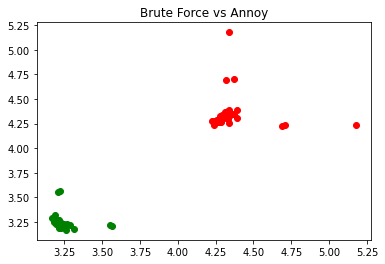

In [64]:
import matplotlib.pyplot as plt

x = list(without_ann.values())
y = sorted(x)

x2 = list(with_ann.values())
y2 = sorted(x2)
plt.title("Brute Force vs Annoy")
plt.scatter(x, y,color="red")
plt.scatter(x2,y2,color='green')
plt.show()

In [ ]:
# interaction = pd.pivot_table(df, index='userId', columns='movieId', values='rating')
# interaction = interaction.fillna(0)
# all_csr = csr_matrix(interaction.values)
# (train_matrix, test_matrix) = random_train_test_split(all_csr, test_percentage=0.3)
# !pip install pandasql
# from pandasql import sqldf
# pysqldf = lambda q: sqldf(q, globals())
#Fix data that is only rated in 2018
# uids = pysqldf('select distinct(userId) from train_data;')
# uid_train_set = set()
# for index,row in uids.iterrows():
#   uid_train_set.add(row['userId'])
# uids = pysqldf('select distinct(userId) from val_data;')
# uid_val_set = set()
# for index,row in uids.iterrows():
#   uid_val_set.add(row['userId'])
# uids = pysqldf('select distinct(userId) from test_data;')
# uid_test_set = set()
# for index,row in uids.iterrows():
#   uid_test_set.add(row['userId'])
# for_val = uid_val_set.difference(uid_train_set)
# for_test = uid_test_set.difference(uid_train_set)
# trains = []
# vals = []
# for uid in for_val:
#   sub = pysqldf(f'select * from val_data where userId={uid}')
#   train = sub.sample(frac=0.5)
#   val = sub.drop(train.index)
#   trains.append(train)
#   vals.append(val)
# train = pd.concat(trains)
# val = pd.concat(vals)
# train_data = pd.concat([train_data,train])
# val_data = pd.concat([val_data,val])
# trains = []
# tests = []
# for uid in for_test:
#   sub = pysqldf(f'select * from test_data where userId={uid}')
#   train = sub.sample(frac=0.5)
#   test = sub.drop(train.index)
#   trains.append(train)
#   tests.append(test)
# train = pd.concat(trains)
# test = pd.concat(tests)
# train_data = pd.concat([train_data,train])
# test_data = pd.concat([test_data,test])
# # Data Transform
# # train_data = scipy.sparse.coo_matrix((train_data.rating, (train_data.movieId, train_data.userId)))
# train_data = pd.pivot_table(train_matrix, index='userId', columns='movieId', values='rating')
# train_data = train_data.fillna(0)
# train_data = csr_matrix(train_data.values)
# # val_data = scipy.sparse.coo_matrix((val_data.rating, (val_data.movieId, val_data.userId)))
# val_data = pd.pivot_table(val_data, index='userId', columns='movieId', values='rating')
# val_data = val_data.fillna(0)
# val_data = csr_matrix(val_data.values)
# test_data = pd.pivot_table(test_data, index='userId', columns='movieId', values='rating')
# test_data = test_data.fillna(0)
# test_data = csr_matrix(test_data.values)
# model = LightFM(learning_rate=0.05, loss='bpr')
# model.fit(train_data, epochs=10)
# train_precision = precision_at_k(model, train_data, k=10).mean()
# train_auc = auc_score(model, train_data).mean()
# val_precision = precision_at_k(model, val_data, k=10).mean()
# val_auc = auc_score(model, train_data).mean()